**Import the Neccessary Libraries**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms


**Create a Folder Structure**

In [2]:
import os

# Base directory
base_dir = "/content/plant_data"
images_dir = os.path.join(base_dir, "images")

# Create folders
os.makedirs(images_dir, exist_ok=True)

print(" Folder structure created:")
print(base_dir)
print(images_dir)

 Folder structure created:
/content/plant_data
/content/plant_data/images


**Upload and Extract ZIP file on Colab**

In [3]:
from google.colab import files
uploaded = files.upload()

Saving sample_submission.csv to sample_submission.csv
Saving test.csv to test.csv
Saving train.csv to train.csv


In [4]:
import shutil
import os

csv_files = ["train.csv", "test.csv", "sample_submission.csv"]
for file in csv_files:
    if os.path.exists(file):
        shutil.copy(file, base_dir) # Changed move to copy
print("CSV files copied to:", base_dir)

CSV files copied to: /content/plant_data


In [12]:
from google.colab import files
uploaded = files.upload()

Saving images.zip to images.zip


**Unzip the Folder Images**

In [13]:
import zipfile

with zipfile.ZipFile("images.zip", 'r') as zip_ref:
    zip_ref.extractall(images_dir)

print(f" Images extracted to {images_dir}")

 Images extracted to /content/plant_data/images


In [16]:
import os
print(os.listdir(base_dir))
print(os.listdir(base_dir + '/images/images')[:5])  # show first 5 image files

['images', 'train.csv', 'test.csv', 'sample_submission.csv']
['Test_1011.jpg', 'Test_1717.jpg', 'Test_1794.jpg', 'Train_1567.jpg', 'Train_375.jpg']


**Move Files Inside The Folder**

In [22]:
import os
import shutil

nested_dir = "/content/plant_data/images/images"
target_dir = "/content/plant_data/images"

# Move all image files up one level
for filename in os.listdir(nested_dir):
    shutil.move(os.path.join(nested_dir, filename), target_dir)

# Remove the now-empty nested folder
os.rmdir(nested_dir)

print("✅ Fixed image path. All images moved to:", target_dir)


✅ Fixed image path. All images moved to: /content/plant_data/images


**Loading CSV Files**

In [23]:
import pandas as pd
import os


base_dir = "/content/plant_data"

# Load CSV files
train_df = pd.read_csv(os.path.join(base_dir, "train.csv"))
test_df = pd.read_csv(os.path.join(base_dir, "test.csv"))
sample_submission = pd.read_csv(os.path.join(base_dir, "sample_submission.csv"))

# Add full image paths to both dataframes
train_df['filepath'] = train_df['image_id'].apply(lambda x: os.path.join(base_dir, "images", f"{x}.jpg"))
test_df['filepath'] = test_df['image_id'].apply(lambda x: os.path.join(base_dir, "images", f"{x}.jpg"))

train_df.head()


,image_id,healthy,multiple_diseases,rust,scab,filepath
0,Train_0,0,0,0,1,/content/plant_data/images/Train_0.jpg
1,Train_1,0,1,0,0,/content/plant_data/images/Train_1.jpg
2,Train_2,1,0,0,0,/content/plant_data/images/Train_2.jpg
3,Train_3,0,0,1,0,/content/plant_data/images/Train_3.jpg
4,Train_4,1,0,0,0,/content/plant_data/images/Train_4.jpg


In [24]:
test_df.head()

,image_id,filepath
0,Test_0,/content/plant_data/images/Test_0.jpg
1,Test_1,/content/plant_data/images/Test_1.jpg
2,Test_2,/content/plant_data/images/Test_2.jpg
3,Test_3,/content/plant_data/images/Test_3.jpg
4,Test_4,/content/plant_data/images/Test_4.jpg


In [25]:
sample_submission.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.25,0.25,0.25,0.25
1,Test_1,0.25,0.25,0.25,0.25
2,Test_2,0.25,0.25,0.25,0.25
3,Test_3,0.25,0.25,0.25,0.25
4,Test_4,0.25,0.25,0.25,0.25


**Extract HandiCrafted Feature from Trainin Images**

In [26]:
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from tqdm import tqdm

radius = 1
n_points = 8 * radius
METHOD = 'uniform'

# Function to extract features
def extract_features(img_path):
    try:
        img = cv2.imread(img_path)
        img = cv2.resize(img, (128, 128))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


        hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8],
                            [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()


        lbp = local_binary_pattern(gray, n_points, radius, METHOD)
        (lbp_hist, _) = np.histogram(lbp.ravel(),
                                     bins=np.arange(0, n_points + 3),
                                     range=(0, n_points + 2))
        lbp_hist = lbp_hist.astype("float")
        lbp_hist /= (lbp_hist.sum() + 1e-7)


        features = np.hstack([hist, lbp_hist])
        return features

    except:
        print(f"Error processing {img_path}")
        return np.zeros(512 + n_points + 2)

train_features = []
for path in tqdm(train_df['filepath']):
    feats = extract_features(path)
    train_features.append(feats)


X_train = np.array(train_features)

y_train = train_df[['healthy', 'multiple_diseases', 'rust', 'scab']].values.argmax(axis=1)


100%|██████████| 1821/1821 [00:38<00:00, 47.21it/s]


**Visualize the Data**

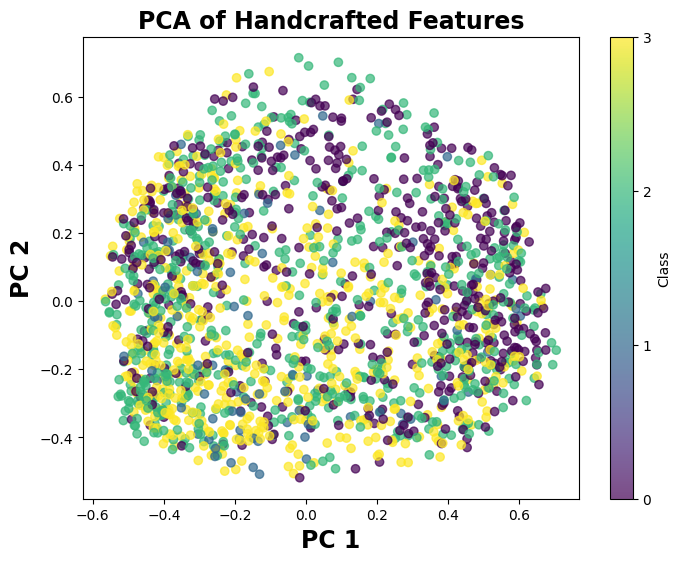

In [27]:

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)


plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis', alpha=0.7)
plt.title("PCA of Handcrafted Features",fontdict={"fontweight":"bold","fontsize":17})
plt.xlabel("PC 1",fontdict={"fontweight":"bold","fontsize":17})
plt.ylabel("PC 2",fontdict={"fontweight":"bold","fontsize":17})
plt.colorbar(scatter, ticks=[0,1,2,3], label='Class')
plt.show()


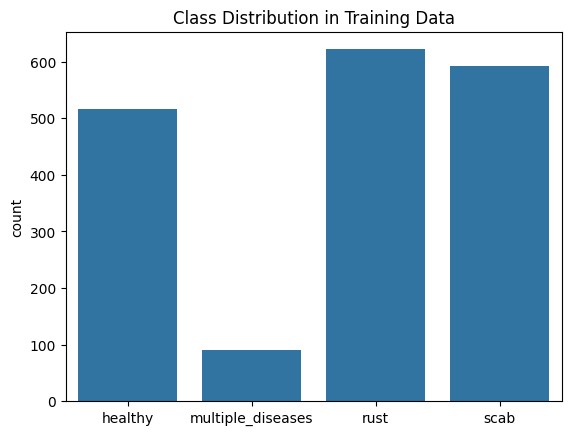

In [28]:
import seaborn as sns

class_names = ['healthy', 'multiple_diseases', 'rust', 'scab']
sns.countplot(x=y_train)
plt.xticks(ticks=[0,1,2,3], labels=class_names)
plt.title("Class Distribution in Training Data")
plt.show()


**Train a Traditional ML Models**

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Split into training and validation sets
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Train Random Forest
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_tr, y_tr)

y_pred = clf.predict(X_val)


accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_val, y_pred, target_names=['healthy', 'multiple_diseases', 'rust', 'scab']))


Validation Accuracy: 80.82%
                   precision    recall  f1-score   support

          healthy       0.76      0.72      0.74       103
multiple_diseases       0.00      0.00      0.00        18
             rust       0.90      0.98      0.93       125
             scab       0.76      0.83      0.79       119

         accuracy                           0.81       365
        macro avg       0.60      0.63      0.62       365
     weighted avg       0.77      0.81      0.79       365



**Confusion Matrix Using Random Forest**

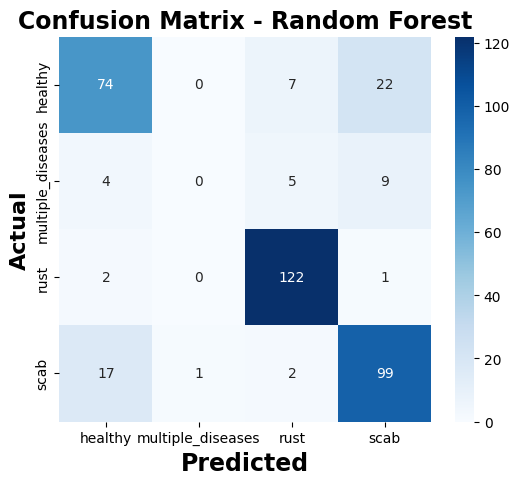

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['healthy', 'multiple_diseases', 'rust', 'scab'],
            yticklabels=['healthy', 'multiple_diseases', 'rust', 'scab'])
plt.xlabel('Predicted',fontdict={"fontweight":"bold","fontsize":17})
plt.ylabel('Actual',fontdict={"fontweight":"bold","fontsize":16})
best_model_name = "Random Forest" # Define best_model_name
plt.title(f'Confusion Matrix - {best_model_name}',fontdict={"fontweight":"bold","fontsize":17})
plt.savefig("confusion_matrix.png")
plt.show()

**Train a Model using Random Forest Model**

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Split into training and validation sets
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Train Random Forest
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_tr, y_tr)

# Predict on validation set
y_pred = clf.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_val, y_pred, target_names=['healthy', 'multiple_diseases', 'rust', 'scab']))


Validation Accuracy: 80.82%
                   precision    recall  f1-score   support

          healthy       0.76      0.72      0.74       103
multiple_diseases       0.00      0.00      0.00        18
             rust       0.90      0.98      0.93       125
             scab       0.76      0.83      0.79       119

         accuracy                           0.81       365
        macro avg       0.60      0.63      0.62       365
     weighted avg       0.77      0.81      0.79       365



**Gradient Boosting Model Calculate the Accuracy of The Dataset**

In [31]:
from sklearn.ensemble import GradientBoostingClassifier

# Train Gradient Boosting Classifier
gbc = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42)
gbc.fit(X_tr, y_tr)

y_pred_gbc = gbc.predict(X_val)
accuracy_gbc = accuracy_score(y_val, y_pred_gbc)
print(f"Gradient Boosting Accuracy: {accuracy_gbc * 100:.2f}%")
print(classification_report(y_val, y_pred_gbc, target_names=['healthy', 'multiple_diseases', 'rust', 'scab']))


Gradient Boosting Accuracy: 78.08%
                   precision    recall  f1-score   support

          healthy       0.73      0.74      0.73       103
multiple_diseases       0.25      0.06      0.09        18
             rust       0.89      0.91      0.90       125
             scab       0.73      0.79      0.76       119

         accuracy                           0.78       365
        macro avg       0.65      0.62      0.62       365
     weighted avg       0.76      0.78      0.77       365



**Train a Model using SVM Model**

In [32]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr)
X_val_scaled = scaler.transform(X_val)

# Train SVM
svm = LinearSVC(max_iter=10000, random_state=42)
svm.fit(X_tr_scaled, y_tr)

y_pred_svm = svm.predict(X_val_scaled)
accuracy_svm = accuracy_score(y_val, y_pred_svm)
print(f"SVM Accuracy: {accuracy_svm * 100:.2f}%")
print(classification_report(y_val, y_pred_svm, target_names=['healthy', 'multiple_diseases', 'rust', 'scab']))


SVM Accuracy: 63.56%
                   precision    recall  f1-score   support

          healthy       0.64      0.56      0.60       103
multiple_diseases       0.04      0.06      0.05        18
             rust       0.75      0.74      0.75       125
             scab       0.63      0.67      0.65       119

         accuracy                           0.64       365
        macro avg       0.52      0.51      0.51       365
     weighted avg       0.65      0.64      0.64       365



**All Three models Like SVM,Gradient Boosting and Random Forest Model using**

In [33]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Split data
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_tr, y_tr)
y_pred_rf = rf.predict(X_val)
acc_rf = accuracy_score(y_val, y_pred_rf)
print(f"Random Forest Accuracy: {acc_rf * 100:.2f}%")

# Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42)
gb.fit(X_tr, y_tr)
y_pred_gb = gb.predict(X_val)
acc_gb = accuracy_score(y_val, y_pred_gb)
print(f"Gradient Boosting Accuracy: {acc_gb * 100:.2f}%")

# SVM (with Standardization)
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr)
X_val_scaled = scaler.transform(X_val)

svm = LinearSVC(max_iter=10000, random_state=42)
svm.fit(X_tr_scaled, y_tr)
y_pred_svm = svm.predict(X_val_scaled)
acc_svm = accuracy_score(y_val, y_pred_svm)
print(f"SVM Accuracy: {acc_svm * 100:.2f}%")


Random Forest Accuracy: 80.82%
Gradient Boosting Accuracy: 78.08%
SVM Accuracy: 63.56%


**Compare all Three Model Accuracy and gives the best Accuracy Model**

In [34]:
model_scores = {
    "Random Forest": acc_rf,
    "Gradient Boosting": acc_gb,
    "SVM": acc_svm
}

# Find the best model
best_model_name = max(model_scores, key=model_scores.get)
best_accuracy = model_scores[best_model_name]

print(f"Best Model: {best_model_name} with {best_accuracy * 100:.2f}% accuracy")


Best Model: Random Forest with 80.82% accuracy


**Predict on Test Images & Create Submission File**

In [36]:
test_features = []
for path in tqdm(test_df['filepath']):
    feats = extract_features(path)
    test_features.append(feats)

X_test = np.array(test_features)

if best_model_name == "SVM":
    test_decision_scores = svm.decision_function(scaler.transform(X_test))
    exp_scores = np.exp(test_decision_scores)
    test_probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

elif best_model_name == "Random Forest":
    test_probs = rf.predict_proba(X_test)

elif best_model_name == "Gradient Boosting":
    test_probs = gb.predict_proba(X_test)



100%|██████████| 1821/1821 [01:05<00:00, 27.83it/s]


In [37]:
from sklearn.preprocessing import OneHotEncoder

test_preds = np.argmax(test_probs, axis=1) # Calculate test_preds from test_probs
onehot = OneHotEncoder(categories=[[0, 1, 2, 3]])
test_preds_oh = onehot.fit_transform(test_preds.reshape(-1, 1)).toarray()

#Create submission DataFrame
submission_df = pd.DataFrame(test_preds_oh, columns=['healthy', 'multiple_diseases', 'rust', 'scab'])
submission_df.insert(0, 'image_id', test_df['image_id'])

submission_df.to_csv("submission.csv", index=False)
print("Submission file saved as 'submission.csv'")

Submission file saved as 'submission.csv'


**Visualize Predictions Test images datasets**

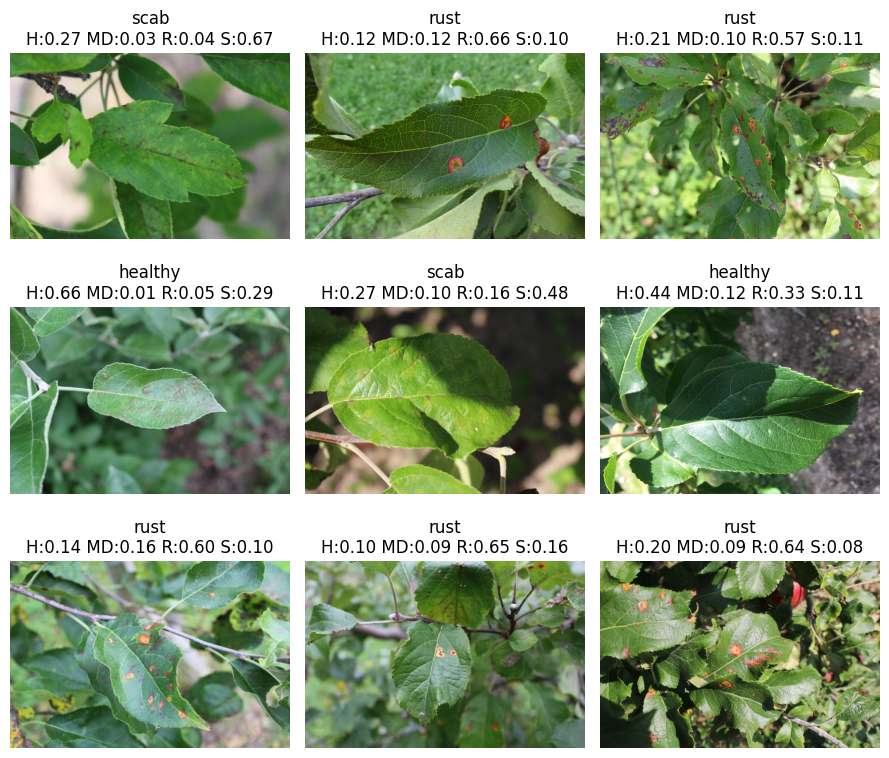

In [38]:
import matplotlib.pyplot as plt
import random

class_names = ['healthy', 'multiple_diseases', 'rust', 'scab']

indices = random.sample(range(len(test_df)), 9)
fig, axes = plt.subplots(3, 3, figsize=(9, 8))

for ax, idx in zip(axes.ravel(), indices):
    img_path = test_df.iloc[idx]['filepath']
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Show image
    ax.imshow(img)
    ax.axis('off')

    # Show predicted class and probs
    probs = test_probs[idx]
    predicted_class = class_names[np.argmax(probs)]
    ax.set_title(f"{predicted_class}\nH:{probs[0]:.2f} MD:{probs[1]:.2f} R:{probs[2]:.2f} S:{probs[3]:.2f}")

plt.tight_layout()
plt.savefig("predictions.png")
plt.show()


**Gradio is an open-source Python package**

In [39]:
!pip install gradio


**Gradio is an allows you to quick builda web application for your Machine Learning Model**

 The process of creating interactive web interfaces for machine learning models, APIs, and other Python functions.

In [52]:
import gradio as gr
import numpy as np
from PIL import Image

def predict_image(images_path):
    if images_path is None:
        return "Please upload an image."


    features = extract_features(images_path)
    features = np.array(features).reshape(1, -1)

    if best_model_name == "SVM":
        test_decision_scores = svm.decision_function(scaler.transform(features))
        exp_scores = np.exp(test_decision_scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)[0]

    elif best_model_name == "Random Forest":
        probs = rf.predict_proba(features)[0]

    elif best_model_name == "Gradient Boosting":
        probs = gb.predict_proba(features)[0]

    else:
        return "Model not defined."

    labels = ['healthy', 'multiple_diseases', 'rust', 'scab']
    return {label: float(prob) for label, prob in zip(labels, probs)}

# Gradio Interface
gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="filepath", label="Upload a Leaf Image"),
    outputs=gr.Label(num_top_classes=4, label="Prediction"),
    title="Leaf Disease Classifier",
    description="Upload a leaf image to classify it into: healthy, rust, scab, or multiple diseases.",
    allow_flagging="never"
).launch()


/usr/local/lib/python3.11/dist-packages/gradio/interface.py:416: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1b967ff72fb42eb0af.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
